# Modeling the Data with Logistic Regression

In [1]:
# import libraries
import os
import string

from dotenv import load_dotenv, find_dotenv
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced
import matplotlib.pyplot as plt
from nltk import word_tokenize
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ConfusionMatrix

%load_ext watermark
%load_ext autoreload
%autoreload 2

PROJ_ROOT = os.path.join(os.pardir)

In [2]:
import sys
src_dir = os.path.join(PROJ_ROOT, "src")
sys.path.append(src_dir)

# import my method from the source code
from features.build_features import clean_and_tokenize

In [3]:
%watermark -a "E. Chris Lynch" -d -t -v -p numpy,pandas,nltk,sklearn

E. Chris Lynch 2019-01-03 22:21:39 

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
pandas 0.23.4
nltk 3.4
sklearn 0.20.1


In [4]:
# load the data
df = pd.read_csv(os.path.join(PROJ_ROOT, 'data', 'processed','clinic_train_data.csv'), index_col=0)

# define text feature
text = df.text.values

# define target
target = df.readmission.values

In [5]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    text, target, stratify=target, test_size=0.33, random_state=42)

## Under-sampling with RandomUnderSample

In [6]:
# instantiate Count Vectorizer
vect = CountVectorizer(max_features=3000, tokenizer=clean_and_tokenize, stop_words='english')

# fit training data to vectorizer
vect_fit = vect.fit_transform(X_train)

In [7]:
vec_params = {'max_features': 3000, 'tokenizer': clean_and_tokenize, 'stop_words': 'english'}
lr_params = {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs', 'random_state': 42}

pipe_rus = make_pipeline_imb(CountVectorizer(**vec_params),
                         RandomUnderSampler(random_state=42),
                         LogisticRegression(**lr_params))

pipe_rus_fit = pipe_rus.fit(X_train, y_train)
y_pred_rus = pipe_rus_fit.predict(X_test)

In [8]:
# print metrics summary
print(classification_report_imbalanced(y_test, y_pred_rus))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.72      0.57      0.82      0.64      0.42     11097
          1       0.11      0.57      0.72      0.19      0.64      0.40       711

avg / total       0.91      0.71      0.58      0.78      0.64      0.41     11808



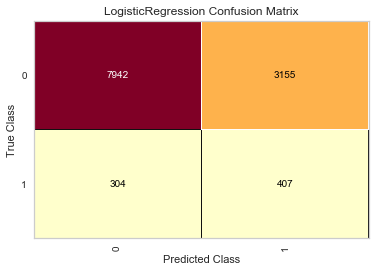

In [15]:
# print confusion matrix
cm = ConfusionMatrix(pipe_rus)

cm.fit(X_train, y_train)

cm.score(X_test, y_test)
cm.poof(outpath=os.path.join(PROJ_ROOT, 'reports',
                               'figures','lr_undersample_confusion_matrix.png'))

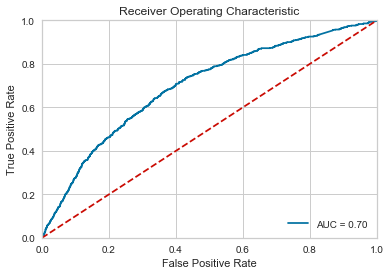

In [10]:
from sklearn.metrics import roc_curve, auc

probs = pipe_rus.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(os.path.join(PROJ_ROOT, 'reports',
                               'figures','lr_undersample_roc_curve.png'))
plt.show()

## Over-sampling with SVMSMOTE

In [11]:
from imblearn.over_sampling import SVMSMOTE

lr_params = {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter':500, 'random_state': 42}

pipe = make_pipeline_imb(CountVectorizer(**vec_params),
                         SVMSMOTE(random_state=42),
                         LogisticRegression(**lr_params))

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# print metrics summary
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.96      0.12      0.95      0.34      0.13     11097
          1       0.16      0.12      0.96      0.14      0.34      0.11       711

avg / total       0.90      0.91      0.17      0.90      0.34      0.12     11808



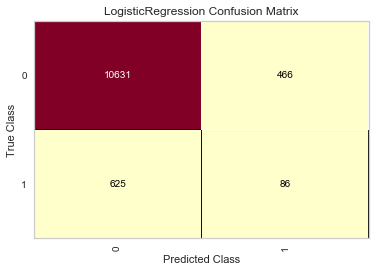

In [12]:
# create pipeline for confusion matrix
pipe = make_pipeline_imb(CountVectorizer(**vec_params),
                         SVMSMOTE(random_state=42),
                         LogisticRegression(**lr_params))

# print confusion matrix
cm = ConfusionMatrix(pipe)

cm.fit(X_train, y_train)

cm.score(X_test, y_test)
cm.poof(outpath=os.path.join(PROJ_ROOT, 'reports',
                               'figures','lr_oversample_confusion_matrix.png'))

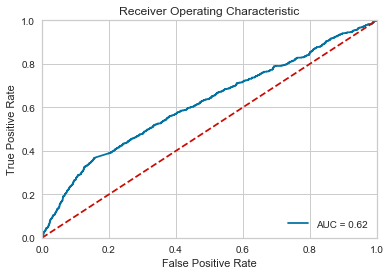

In [14]:
probs = pipe.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(os.path.join(PROJ_ROOT, 'reports',
                               'figures','lr_oversample_curve.png'))
plt.show()